# Péndulo simple sobre un carrito

Se evalúa la respuesta al impulso y se identifica por correlación en condiciones ideales y con muchísima fricción en el eje


In [58]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

M = 1.0   # masa del carro [kg]
m = 0.1   # masa del péndulo [kg]
l = 0.5   # longitud del péndulo [m]
b = 10    # MUCHA fricción en las ruedas del carrito para que no se me vaya con el mínimo impulso --> REVISAR
b2 = 1   # MUCHA fricción en el eje para que las oscilaciones se apaguen rápidamente (y la rta al impulso tenga pocas muestras) --> REVISAR
g = 9.81  # gravedad

h = 0.1   # Me parece que es un buen período de muestreo para caracterizar la dinámica --> REVISAR


# Ecuaciones de estado continuas
def continuous_dynamics(t, state, F):
    x, x_dot, theta, theta_dot = state

    k = int(t/h)
    if k >= len(u):
        k = len(u) - 1
    F = u[k]

    # Construcción de ecuaciones
    denom = M + m*np.sin(theta)**2

    x_ddot = (F - b*x_dot + m*np.sin(theta)*(l*theta_dot**2 + g*np.cos(theta))) / denom
    theta_ddot = (-F*np.cos(theta) - b2*theta_dot - (M+m)*g*np.sin(theta)
                  - m*l*theta_dot**2*np.sin(theta)*np.cos(theta)) / (l*denom)

    return [x_dot, x_ddot, theta_dot, theta_ddot]


## Obtengo la respuesta al impulso (baseline)

Tiempo de muestreo 100.0 ms
Tiempo final: 19.90 s


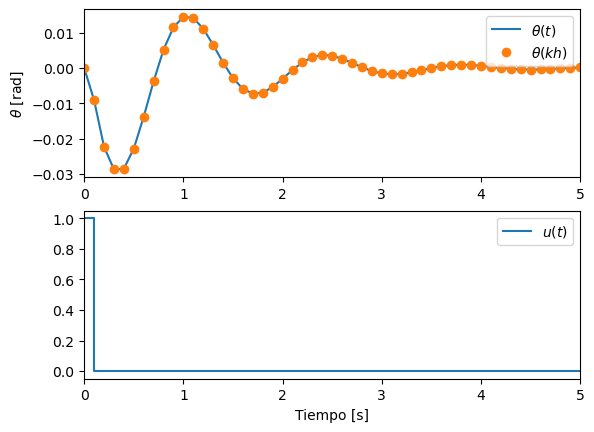

In [59]:

state0_discrete = np.array([0.0, 0.0, 0.0, 0.0])

N = 200
T_final = (N-1)*h
t_eval_cont = np.linspace(0, T_final, N)
print(f"Tiempo de muestreo {h*1000} ms")
print(f"Tiempo final: {T_final:.2f} s")

# Respuesta al impulso
u = np.zeros_like(t_eval_cont)
u[0] = 1

sol_cont = solve_ivp(lambda t, y: continuous_dynamics(t, y, u), (0, T_final), state0_discrete, t_eval=t_eval_cont)
t = sol_cont.t
y = sol_cont.y[2]
g_delta = y/u[0]

plt.subplot(211)
plt.plot(t, y, '-', label='$\\theta(t)$')
plt.plot(t, y, 'o', label='$\\theta(kh)$')
plt.ylabel('$\\theta$ [rad]')
plt.legend()
plt.xlim(0,5)
plt.subplot(212)
plt.step(t,u,where='post',label='$u(t)$')
plt.legend()
plt.xlim(0,5)
plt.xlabel('Tiempo [s]')
plt.show()

## Estimación de la secuencia de ponderación mediante correlación cruzada

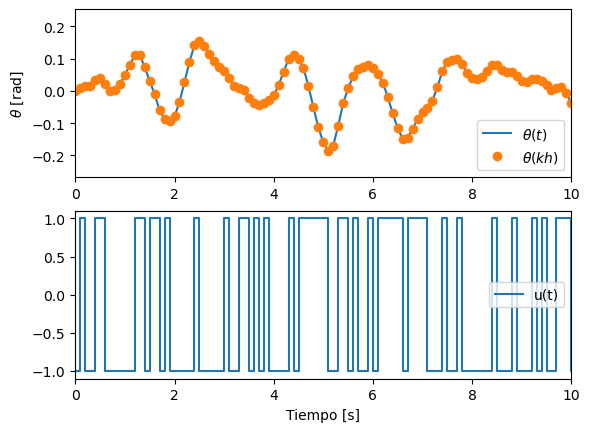

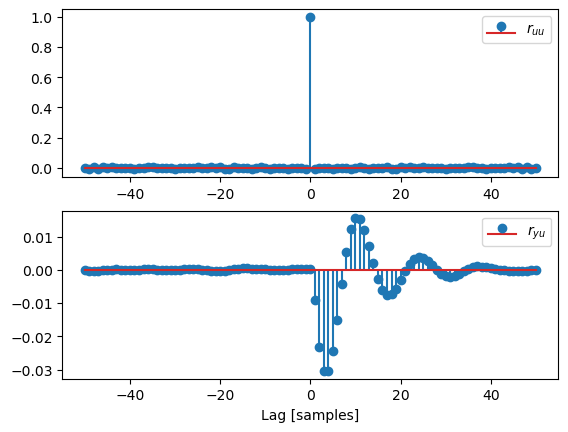

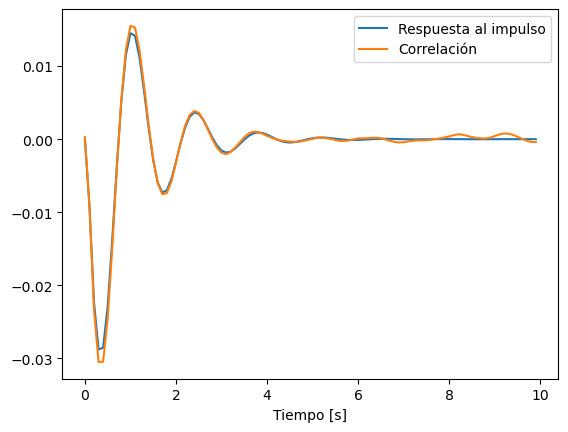

In [60]:
# Tomo muchísimas muestras
# Ver qué pasa cuando disminuye N
N = 50000
T_final = (N-1)*h
t_eval_cont = np.linspace(0, T_final, N)

u = np.sign(np.random.randn(N))

state0_discrete = np.array([0.0, 0.0, 0.0, 0.0])
sol_cont = solve_ivp(lambda t, y: continuous_dynamics(t, y, u), (0, T_final), state0_discrete, t_eval=t_eval_cont)
t = sol_cont.t
y = sol_cont.y[2]

plt.subplot(211)
plt.plot(t, y, '-', label='$\\theta(t)$')
plt.plot(t, y, 'o', label='$\\theta(kh)$')
plt.ylabel('$\\theta$ [rad]')
plt.legend()
plt.xlim(0,10)
plt.subplot(212)
plt.step(t,u,where='post',label='u(t)')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.xlim(0,10)
plt.show()

ruu = np.correlate(u, u, mode="full")/N  # correlación completa
mid = len(ruu)//2                      # índice de lag=0
M = 100
lags = np.arange(-M//2,M//2+1)

ryu = np.correlate(y, u, mode="full")/N  # correlación completa
var_u = np.var(u)
g_hat_corr = ryu[mid+np.arange(0,M)]/var_u

plt.subplot(211)
plt.stem(lags,ruu[mid+lags],label='$r_{{uu}}$')
plt.legend()
plt.subplot(212)
plt.stem(lags,ryu[mid+lags],label='$r_{{yu}}$')
plt.legend() 
plt.xlabel('Lag [samples]')
plt.show()

plt.plot(t[0:M],g_delta[0:M],label='Respuesta al impulso')
plt.plot(t[0:M],g_hat_corr,label='Correlación')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.show()
